In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/CSV files/axis_day_data.csv')
mean_data=df.iloc[:,2:4].mean(axis=1)
df['mean_data']=mean_data
dataset=df[['date','mean_data']]

In [ ]:
from datetime import datetime
#Removed time from date
dataset['date']=pd.to_datetime(dataset['date'])
dataset['date'] = dataset['date'].dt.date
dataset.set_index('date', inplace=True)
dataset.head()

<ipython-input-45-b8f525623aee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['date']=pd.to_datetime(dataset['date'])
<ipython-input-45-b8f525623aee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['date'] = dataset['date'].dt.date


,mean_data
date,
2014-01-01,260.650
2014-01-02,261.700
2014-01-03,252.750
2014-01-06,251.955
2014-01-07,252.330


In [ ]:
dataset.describe()

,mean_data
count,2450.000000
mean,634.394090
std,197.886387
min,222.000000
25%,496.956250
50%,590.312500
75%,752.162500
max,1171.525000


<Axes: xlabel='date'>

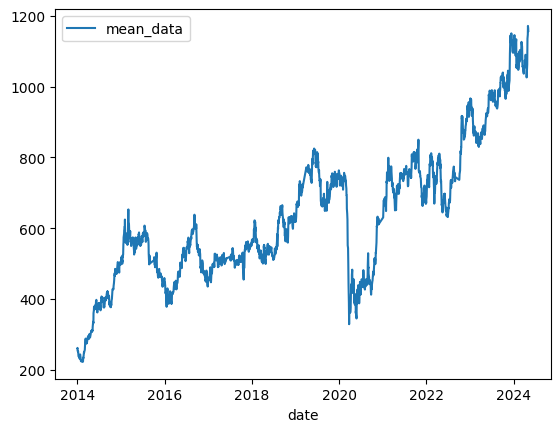

In [ ]:
dataset.plot()

In [ ]:
train=dataset.iloc[:-5]
test=dataset.iloc[-5:]

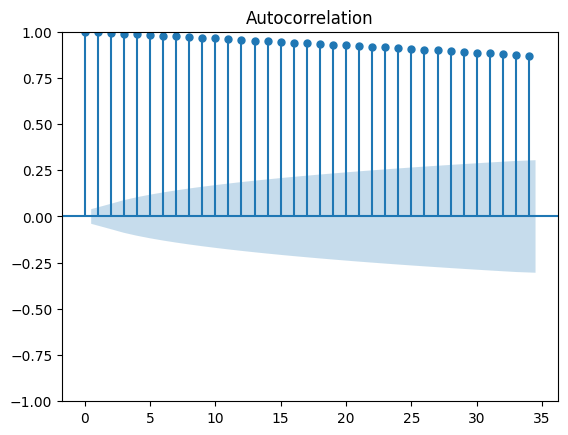

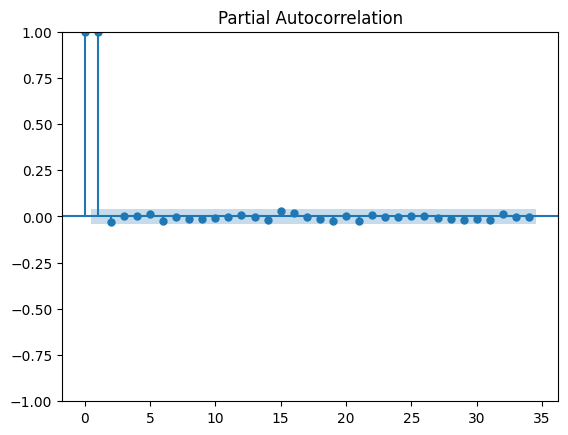

In [ ]:
# check for the stationarity(no seasonality=> no repeating patterns)
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
acf_original=plot_acf(train)
pacf_original=plot_pacf(train)

In [ ]:
#ADF TEST
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(train['mean_data'])
print(f"p-value : {adf_test[1]}")

p-value : 0.7044588505631945


since more p value: declared as non-stationary

# Transform to stationary: differencing

<Axes: xlabel='date'>

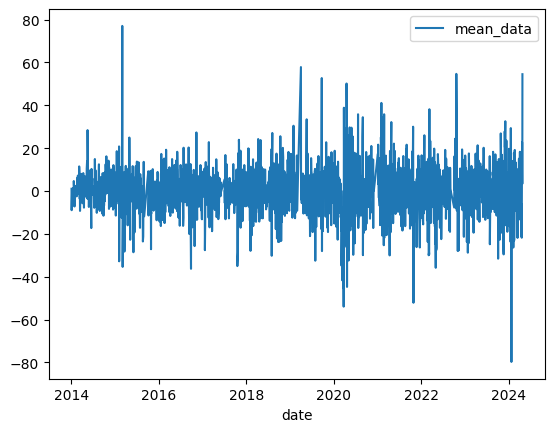

In [ ]:
train_diff=train.diff().dropna()
train_diff.plot()

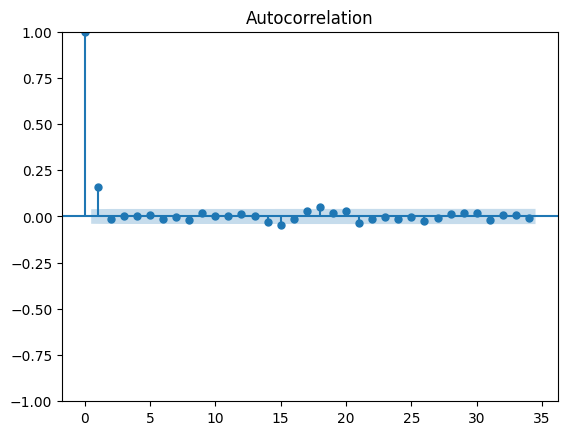

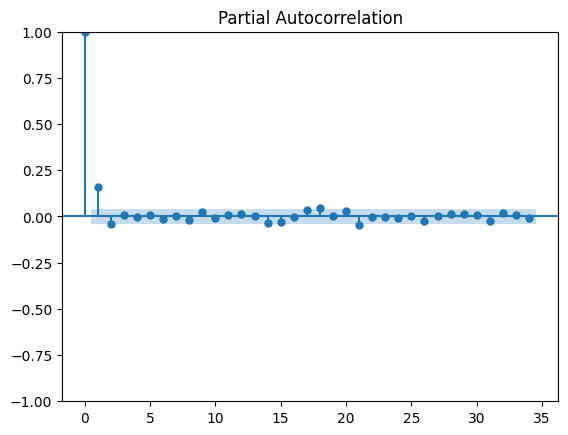

In [ ]:
acf_diff=plot_acf(train_diff)
pacf_diff=plot_pacf(train_diff)

In [ ]:
print(train_diff)

            mean_data
date                 
2014-01-02      1.050
2014-01-03     -8.950
2014-01-06     -0.795
2014-01-07      0.375
2014-01-08     -3.830
...               ...
2024-04-19    -21.800
2024-04-22     22.775
2024-04-23     10.375
2024-04-24      3.350
2024-04-25     54.500

[2444 rows x 1 columns]


In [ ]:
adf_test=adfuller(train_diff['mean_data'])
print(f"p-value : {adf_test[1]}")

p-value : 0.0


<Axes: xlabel='date'>

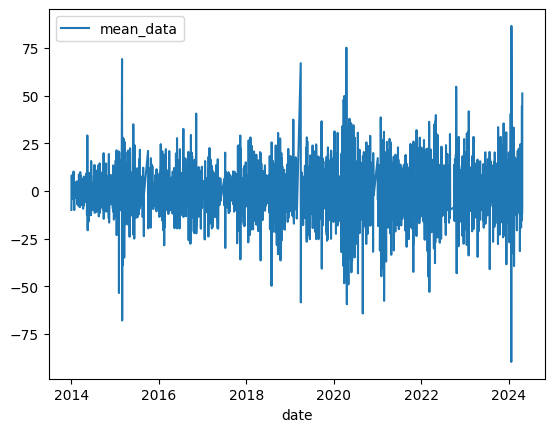

In [ ]:
train_diff2=train_diff.diff().dropna()
train_diff2.plot()

In [ ]:
print(train_diff2)

            mean_data
date                 
2014-01-03    -10.000
2014-01-06      8.155
2014-01-07      1.170
2014-01-08     -4.205
2014-01-09     -3.115
...               ...
2024-04-19    -15.675
2024-04-22     44.575
2024-04-23    -12.400
2024-04-24     -7.025
2024-04-25     51.150

[2443 rows x 1 columns]


In [ ]:
adf_test=adfuller(train_diff2['mean_data'])
print(f"p-value : {adf_test[1]}")

p-value : 9.714969802526091e-29


# determine other arima parameters**(p,1,q)**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['mean_data'],order=(2,1,0))
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              mean_data   No. Observations:                 2445
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -9231.844
Date:                Mon, 10 Jun 2024   AIC                          18469.688
Time:                        08:26:33   BIC                          18487.092
Sample:                             0   HQIC                         18476.014
                               - 2445                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1710      0.016     10.980      0.000       0.140       0.202
ar.L2         -0.0397      0.016     -2.562      0.010      -0.070      -0.009
sigma2       111.8671      1.717     65.163      0.000     108.502     115.232
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2535.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

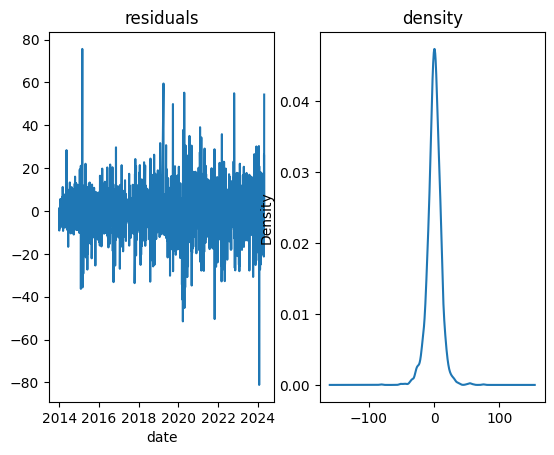

In [ ]:
# compare the residuals
residuals=model_fit.resid[1:]
fig,ax=plt.subplots(1,2)
residuals.plot(title='residuals',ax=ax[0])
residuals.plot(title='density',kind='kde',ax=ax[1])
plt.show()

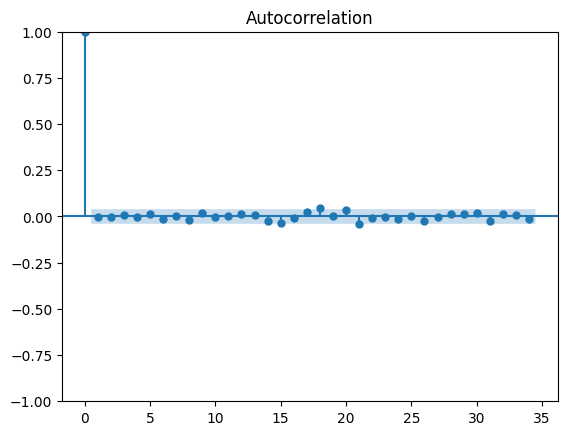

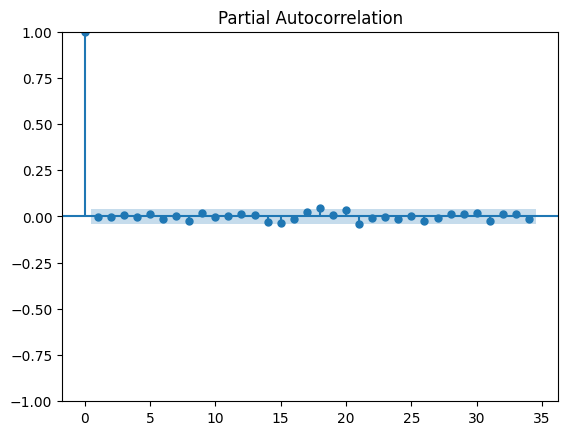

In [ ]:
acf_residuals=plot_acf(residuals)
pacf_residuals=plot_pacf(residuals)

Autofit the arima model

In [ ]:
!pip install pmdarima
import pmdarima as pm
auto_model=pm.auto_arima(train,stepwise=False,seasonal=False)
auto_model

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [ ]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2445
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -9230.888
Date:                Mon, 10 Jun 2024   AIC                          18467.777
Time:                        08:27:41   BIC                          18485.181
Sample:                             0   HQIC                         18474.103
                               - 2445                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3543      0.251      1.411      0.158      -0.138       0.847
ma.L1          0.1731      0.015     11.253      0.000       0.143       0.203
sigma2       111.7280      1.712     65.250      0.000     108.372     115.084
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2536.30
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_test=auto_model.predict(n_periods=len(test))
pred_test

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


2445    1126.639584
2446    1126.993911
2447    1127.348237
2448    1127.702564
2449    1128.056891
dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae ,mean_absolute_percentage_error as mape
mse_error=mse(test,pred_test)
mae_error=mae(test,pred_test)
mape_error=mape(test,pred_test)
print(f"MSE:{mse_error}")
print(f"MAE:{mae_error}")
print(f"MAPE:{mape_error}")

MSE:934.5284841572859
MAE:27.936762578935667
MAPE:0.02406582956683017


# Manual arima model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: >

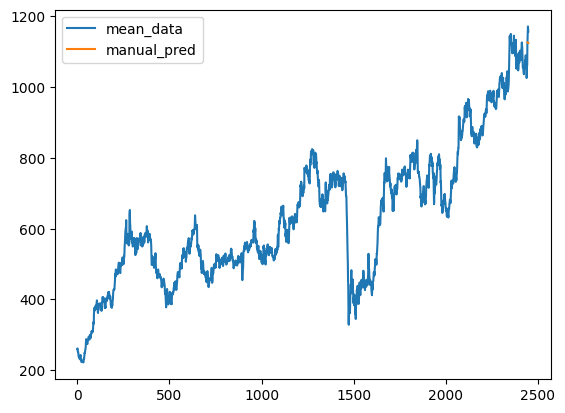

In [ ]:
manual_pred=model_fit.forecast(len(test))
df['manual_pred']=[None]*len(train) + list(manual_pred)
fig.size=(12,10)
df[['mean_data','manual_pred']].plot()